<a href="https://colab.research.google.com/github/dylanh05/pyDFT/blob/master/1DDFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [59]:
class DFT:
    # Space must be a 1D np.linspace and grid is equal length vector of values over the space
    # v_ext is the applied potential to the grid (only supports harmonic oscillator)
    # v_ext = 'harmonic' applies harmonic oscillator to the Hamiltonian
    def __init__(self, space, grid, v_ext):
        self.space = space
        self.dx = space[1] - space[0]
        self.grid = grid
        self.v_ext = v_ext

    # Plots the DFT grid on the 1D space it spans
    def plot_grid(self):
        print("DFT grid")
        plt.plot(self.space, self.grid)

    # Returns magnitde of a 1D vector
    def magnitude(self, vector):
        sum = 0
        for i in range(vector.size):
            sum += vector[i]**2
        return math.sqrt(sum)

    # Plots an arbitrary function on the DFT space, requires self.grid.size == function.size
    def plot_function_over_space(self, function):
        plt.plot(self.space, function)

    # Gets the index of the first occurance of value in the DFT grid
    def get_index_grid(self, value):
        return np.where(self.grid==value)[0][0]

    # Gets the index of the state associated with the input energy
    def get_index_state(self, energy, epsilon_n):
        return np.where(energy == epsilon_n)[0][0]

    # Applies NxN operator to 1xN grid
    def linear_operator(self, operator):
        return np.dot(operator, self.grid)

    # Returns finite differences operator for single differentiation
    def deriv(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        for i in range(0, self.grid.size):
            if i != self.grid.size-1:
                operator[i][i+1] = -1
                operator[i+1][i] = 1
        operator = operator / (-2* self.dx)
        return operator

    # Returns finite differences operator for twice differentiation
    def deriv2(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        for i in range(0, self.grid.size):
            operator[i][i] = 1
            if i <= self.grid.size-3:
                operator[i][i+1] = -2
                operator[i][i+2] = 1
        operator = operator / ((self.dx)**2)
        return operator

    # Returns grids of first and second derivatives of grid over the DFT space
    def compute_derivs(self):
        first_derivs = self.linear_operator(self.deriv())
        second_derivs = self.linear_operator(self.deriv2())
        # The derivative get fuzzy at the endpoints, so we will exclude these
        first_derivs[0] = first_derivs[1]
        first_derivs[first_derivs.size-1] = first_derivs[first_derivs.size-2]
        second_derivs[0] = second_derivs[1]
        second_derivs[second_derivs.size-2:second_derivs.size] = second_derivs[second_derivs.size-3]
        return first_derivs, second_derivs

    # Gives the matrix representation of the kinetic operator applied to function over a grid
    # using the finite difference approximation
    # Approximations can be modified to use numerical differentiation contained within class
    def kinetic_operator(self):
        dx = self.space[1] - self.space[0]
        operator = self.deriv2()
        return (-1/2)*operator

    # Returns the external potential chosen as a matrix to apply to the hamiltonian
    def external_potential(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        if self.v_ext == "harmonic":
            for i in range(self.grid.size):
                operator[i][i] = self.grid[i]
            return operator
        print("External potential chosen: " + str(self.v_ext) + " not yet supported")

    # Formats potential into operator form to apply to the hamiltonian
    def potential(self, v):
        operator = np.zeros((self.space.size, self.space.size))
        for i in range(self.space.size):
            operator[i][i] = v[i]
        return operator

    # Uses simple kinetic operator and potentials as the Hamiltonian, diagonalizes it, and computes Kohm Sham states
    def compute_Kohm_Sham_states(self, exc_potential):
        Hamiltonian = self.kinetic_operator() + self.external_potential() + self.potential(exc_potential)
        epsilon_n, psi_gn = np.linalg.eigh(Hamiltonian)
        
        # Numerical differentiation gets fuzzy at the endpoints, so we will set
        # these to an arbitrarily high energy so we dont consider these wavefunctions
        # in later DFT calculations
        epsilon_n[0] = 10000
        epsilon_n[epsilon_n.size-1] = 10000
        return epsilon_n, psi_gn

    # Integrates inputted function over the DFT grid, return area under curve
    def integrate(self, function):
        dh = self.space[1]-self.space[0]
        area = 0
        for i in range(0, self.grid.size):
            area += function[i]*dh
        return area

    # Normalizes all states in psi_gn
    def normalize(self, psi_gn):
        for i in range(self.grid.size):
            area = self.integrate(np.abs(psi_gn[i])**2)
            psi_gn[i] = (np.abs(psi_gn[i])**2)/area
        return psi_gn

    # Plots a state at a given index and the energy associated with it
    def plot_wavefuction(self, epsilon_n, psi_gn, ind):
        print("Energy: " + str(epsilon_n[ind]))
        plt.plot(space, psi_gn[:, ind])
        plt.show()

    # Returns the indices of n_states with lowest energy
    def find_ground_states(self, epsilon_n, n_elec):
        n_states = math.ceil(n_elec/2)
        lowest_energys = epsilon_n[np.argpartition(epsilon_n, n_states)[:n_states]]
        inds = []
        for i in range(n_states):
            inds.append(self.get_index_state(lowest_energys[i], epsilon_n))
        return inds

    # Returns list of electron occupation of each state in the DFT grid
    def get_electron_occupation(self, epsilon_n, n_elecs):
        inds = self.find_ground_states(epsilon_n,  n_elecs)
        occupation = [0 for i in range(self.space.size)]
        for i in range(0, n_elecs):
            occupation[inds[math.floor(i/2)]] += 1
        return occupation

    # Returns the electron density of electrons on the DFT space, psi_gn must be normalized
    # This needs to be tested further
    def electron_density(self, epsilon_n, psi_gn_normalized, n_elecs):
        occupation = self.get_electron_occupation(epsilon_n, n_elecs)
        n = np.zeros(self.space.size)
        # Loop over every state
        for i in range(n.size):
            # Loop over every grid point
            for j in range(n.size):
                n[i] += occupation[j] * math.sqrt((psi_gn_normalized[j, i]**2))
        return n

    # Returns the exchange energy and potential using local density approximation, ignoring
    # correlation in the exchange functional for simplicity
    def compute_exchange(self, density):
        energy = self.integrate((-3/4)*((3/(math.pi)**(1/3)))*(density**(4/3)))
        potential = -(3/(math.pi))**(1/3)*(density**(1/3))
        return energy, potential

    def compute_coulomb(self, density):
        energy = 6
        potential = 6
        return energy, potential

    def scf_cycle(self, n_elecs):
        last_density = np.zeros(self.space.size)
        change_in_density = np.ones(self.space.size)
        change = 1000
        while change > .1:
            exc_energy, exc_potential = self.compute_exchange(last_density)
            print("Exchange energy: " + str(exc_energy))
            
            epsilon_n, psi_gn = self.compute_Kohm_Sham_states(exc_potential)
            psi_gn = State.normalize(psi_gn)
            density = self.electron_density(epsilon_n, psi_gn, n_elecs)
            
            change = self.magnitude(density-last_density)
            print(change)
            last_density = density
        self.plot_function_over_space(last_density)

In [60]:
n_partitions = 1000
space = np.linspace(0, 6, n_partitions)
print("1D DFT Space: ")
print(space)

1D DFT Space: 
[0.      0.00601 0.01201 0.01802 0.02402 0.03003 0.03604 0.04204 0.04805
 0.05405 0.06006 0.06607 0.07207 0.07808 0.08408 0.09009 0.0961  0.1021
 0.10811 0.11411 0.12012 0.12613 0.13213 0.13814 0.14414 0.15015 0.15616
 0.16216 0.16817 0.17417 0.18018 0.18619 0.19219 0.1982  0.2042  0.21021
 0.21622 0.22222 0.22823 0.23423 0.24024 0.24625 0.25225 0.25826 0.26426
 0.27027 0.27628 0.28228 0.28829 0.29429 0.3003  0.30631 0.31231 0.31832
 0.32432 0.33033 0.33634 0.34234 0.34835 0.35435 0.36036 0.36637 0.37237
 0.37838 0.38438 0.39039 0.3964  0.4024  0.40841 0.41441 0.42042 0.42643
 0.43243 0.43844 0.44444 0.45045 0.45646 0.46246 0.46847 0.47447 0.48048
 0.48649 0.49249 0.4985  0.5045  0.51051 0.51652 0.52252 0.52853 0.53453
 0.54054 0.54655 0.55255 0.55856 0.56456 0.57057 0.57658 0.58258 0.58859
 0.59459 0.6006  0.60661 0.61261 0.61862 0.62462 0.63063 0.63664 0.64264
 0.64865 0.65465 0.66066 0.66667 0.67267 0.67868 0.68468 0.69069 0.6967
 0.7027  0.70871 0.71471 0.72072 0.726

In [61]:
x = np.random.rand(n_partitions)
print("DFT Grid: ")
print(x)

DFT Grid: 
[0.28021 0.94951 0.07016 0.48355 0.92585 0.79872 0.37518 0.06205 0.88296
 0.12505 0.72712 0.22096 0.66471 0.97841 0.93468 0.68824 0.18076 0.46156
 0.03707 0.45482 0.34781 0.61128 0.19926 0.36714 0.04766 0.78145 0.61714
 0.47777 0.05589 0.06576 0.76691 0.70897 0.76786 0.27399 0.43547 0.74599
 0.61679 0.11494 0.02124 0.22964 0.28671 0.09987 0.64353 0.8085  0.67216
 0.29642 0.74643 0.62627 0.47044 0.78567 0.56837 0.77777 0.79783 0.74355
 0.40683 0.80875 0.20988 0.96508 0.82179 0.10893 0.8038  0.79415 0.19835
 0.2023  0.84084 0.13381 0.04692 0.16647 0.70209 0.46043 0.59996 0.29014
 0.84462 0.95974 0.08829 0.28639 0.60307 0.92659 0.81956 0.2822  0.48
 0.18474 0.53661 0.45663 0.14762 0.95797 0.65991 0.59321 0.25674 0.04541
 0.89675 0.03781 0.57084 0.18092 0.38754 0.9662  0.78306 0.81972 0.37096
 0.06206 0.82676 0.82259 0.32993 0.15031 0.59171 0.53818 0.22626 0.72359
 0.48755 0.02172 0.90578 0.54376 0.07664 0.81782 0.84436 0.9543  0.33125
 0.3034  0.5078  0.48359 0.7289  0.17192 0.

DFT grid


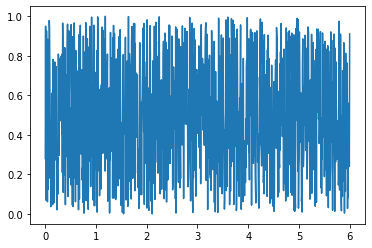

In [62]:
State = DFT(space, x, "harmonic")
State.plot_grid()

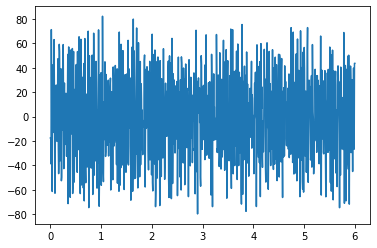

In [63]:
first_derivs, second_derivs = State.compute_derivs()
State.plot_function_over_space(first_derivs)

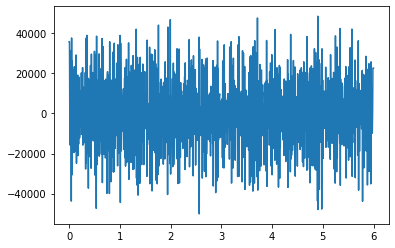

In [64]:
State.plot_function_over_space(second_derivs)

In [65]:
exc_potential = np.zeros(State.space.size)
epsilon_n, psi_gn = State.compute_Kohm_Sham_states(exc_potential)

Energy: -13861.033023131075


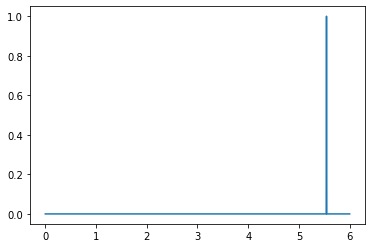

In [66]:
State.plot_wavefuction(epsilon_n, psi_gn, 100)

Energy: -13861.033023131075


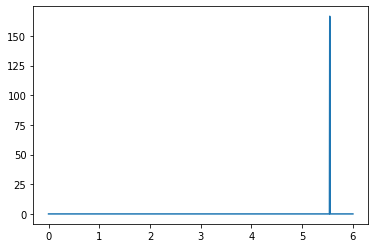

In [67]:
psi_gn = State.normalize(psi_gn)
State.plot_wavefuction(epsilon_n, psi_gn, 100)

In [68]:
print(State.integrate(psi_gn[4]))

1.0


7.0


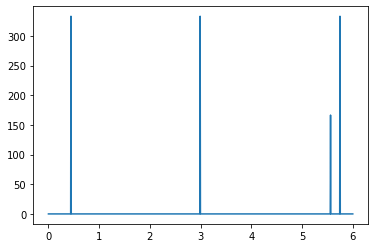

In [69]:
n = State.electron_density(epsilon_n, psi_gn, 7)
plt.plot(space, n)
print(State.integrate(n))

In [70]:
density = np.random.rand(n_partitions)
energy, potential = State.compute_exchange(density)

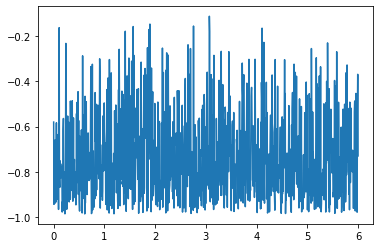

In [71]:
State.plot_function_over_space(potential)

Exchange energy: 0.0
600.3242873647542
Exchange energy: -72.34142130059018
666.0
Exchange energy: -72.34142130059018
470.93311627024065
Exchange energy: -72.34142130059018
0.0


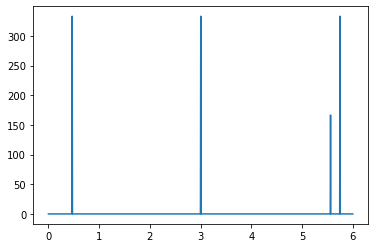

In [72]:
State.scf_cycle(7)